In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os
import h5py
from joblib import Parallel, delayed
sys.path.append('../')
from packages import actv_analysis, svm, load_csv, stats, objects, test_codes
import pickle
import re
import glob

In [6]:
units[0].anova2_numbers

In [12]:
sel_units = [units[i].id for i in range(len(units)) if units[i].anova2_numbers is not None and units[i].anova2_numbers < 0.01 and 
             units[i].anova2_sizes is not None and units[i].anova2_sizes < 0.01]

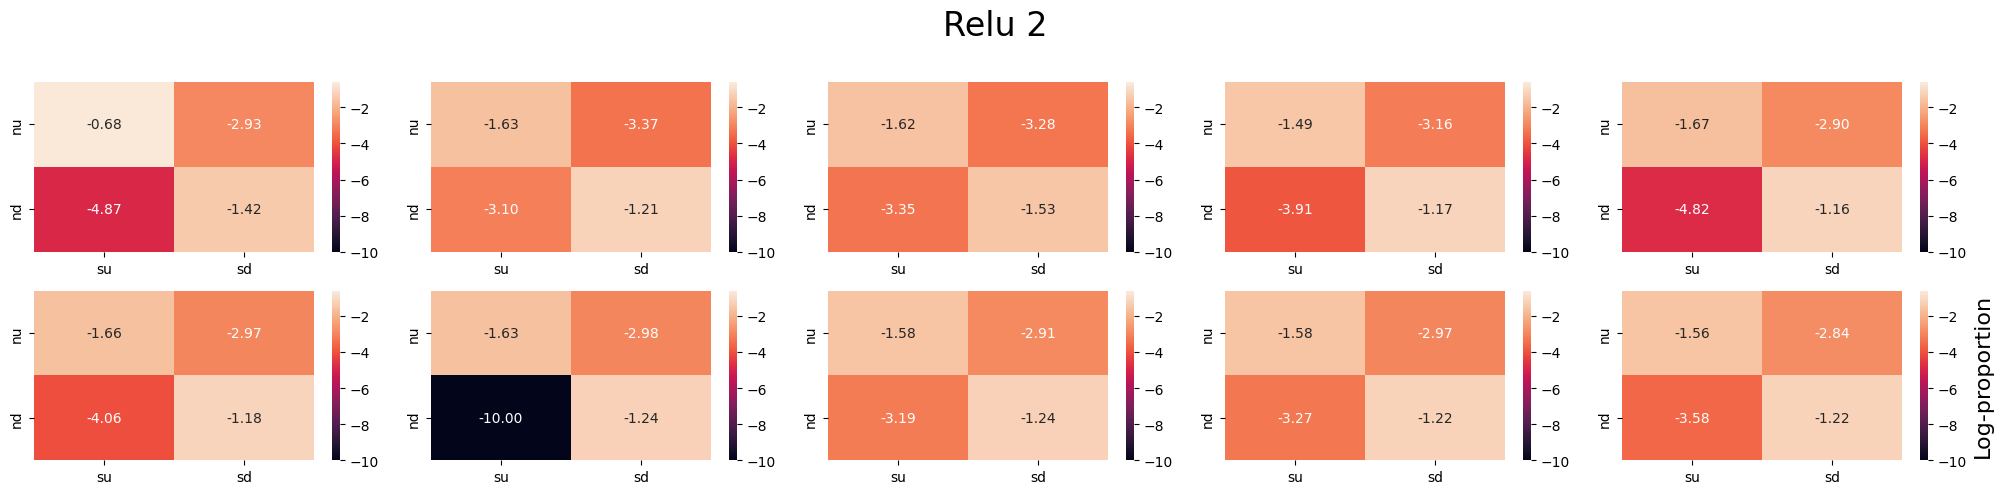

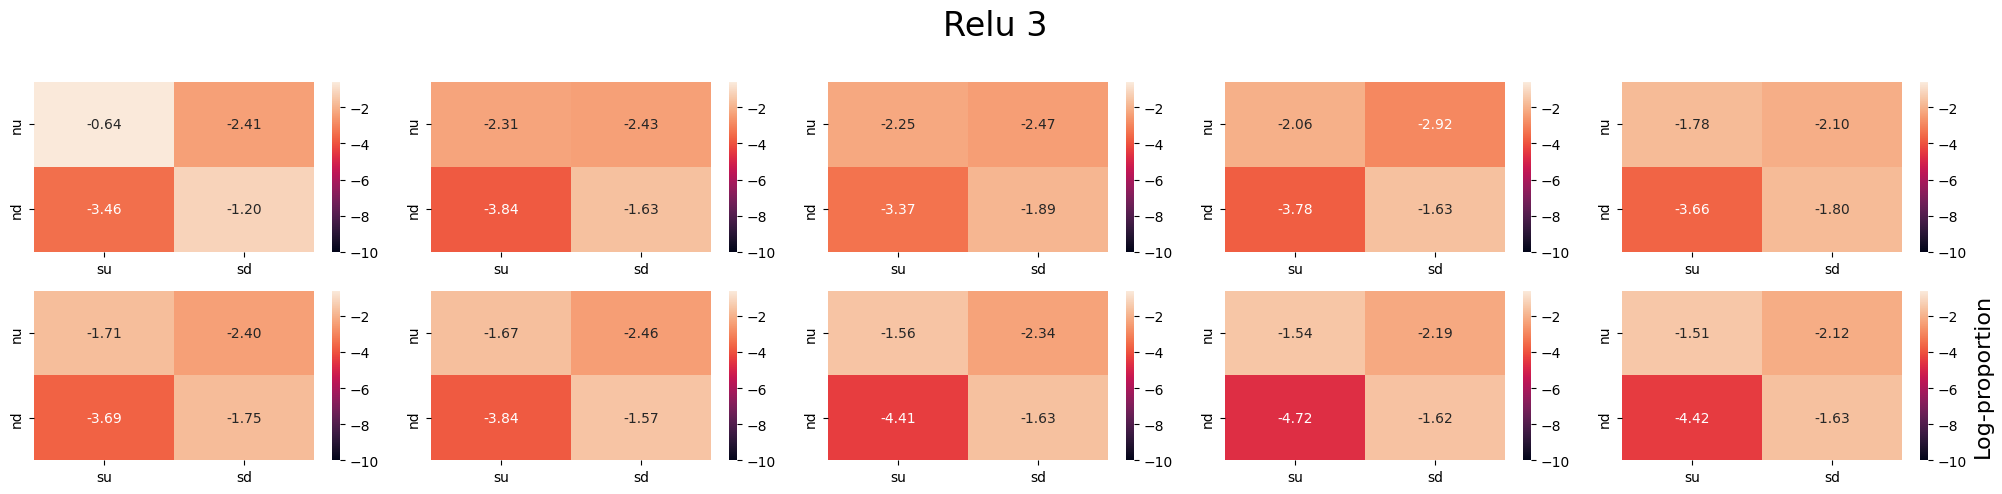

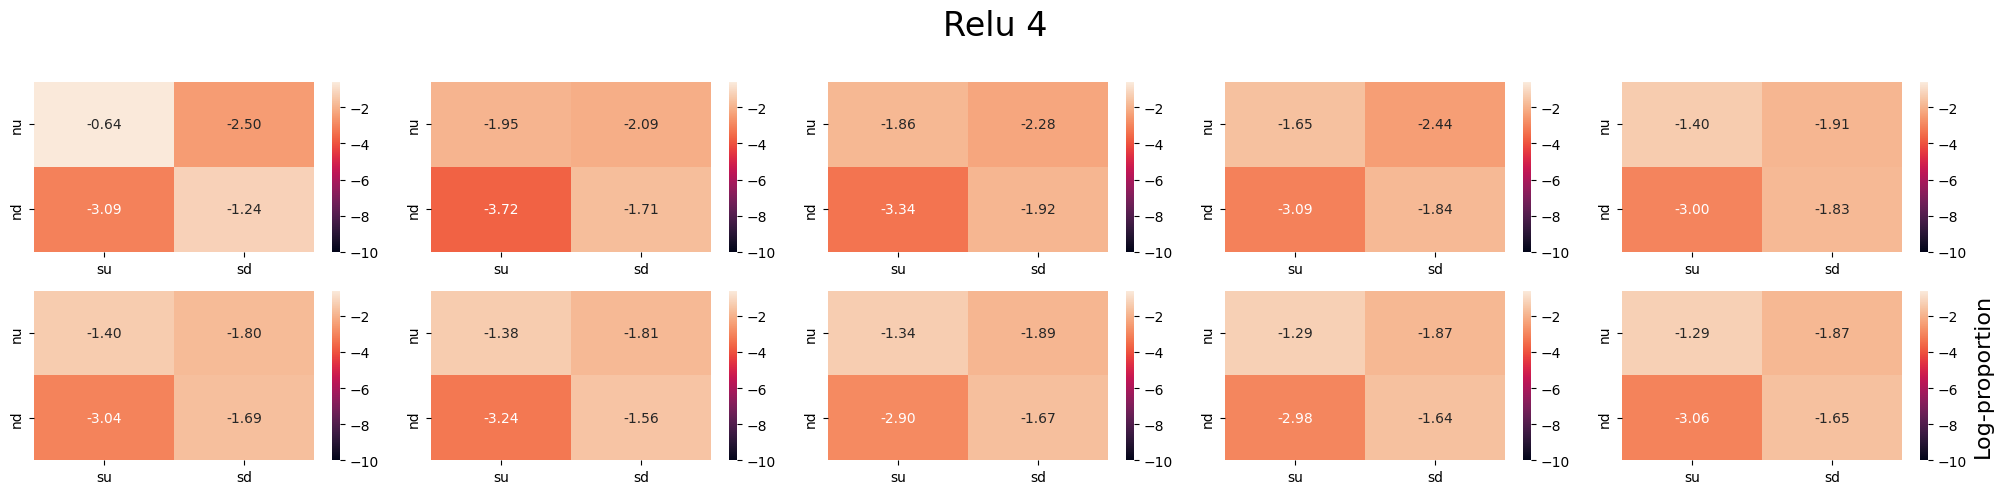

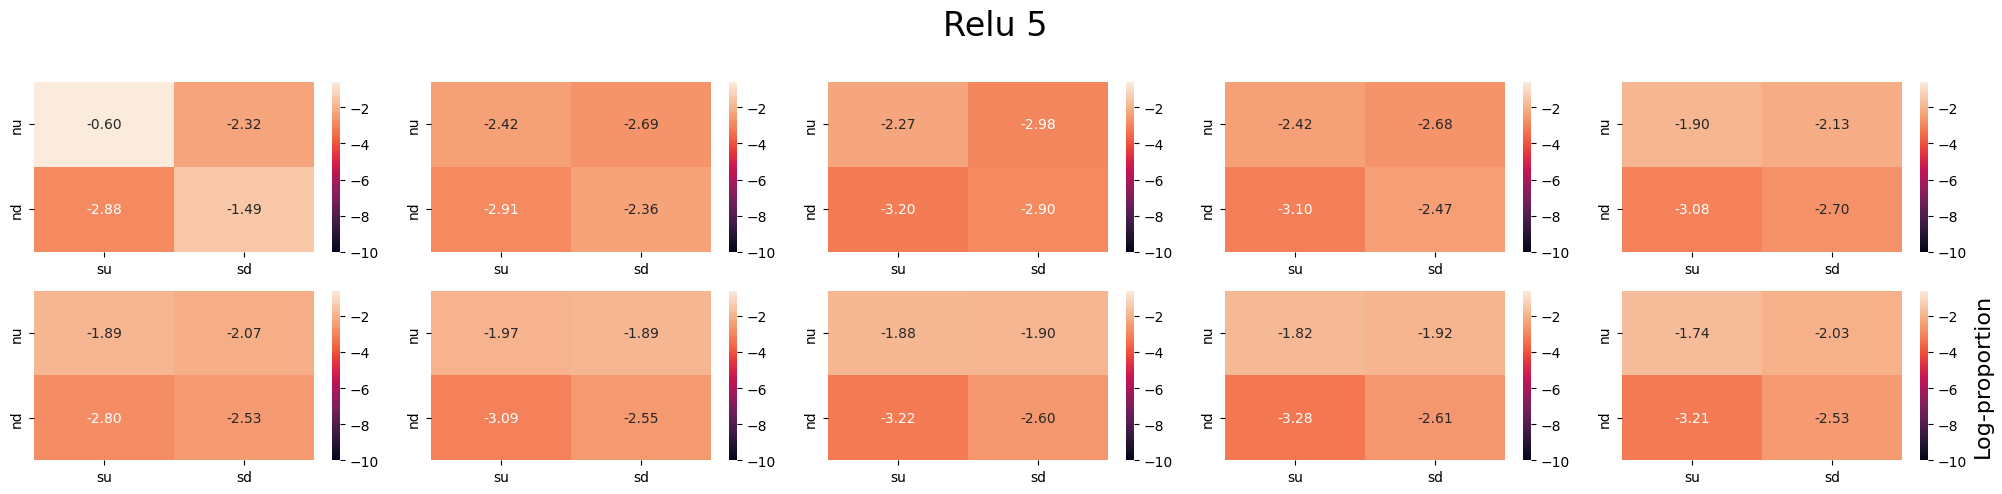

In [22]:
net=1
ns_up_or_down_all = []  # store all dfs for all ReLUs

for relu in range(2,6):
    ns_up_or_down = []
    for epoch in range(0,91,10):
        pkl_filename = f'pkl/network{net}_Relu{relu}_epoch{epoch}.pkl'
        
        if os.path.exists(pkl_filename):
            try:
                with open(pkl_filename, 'rb') as f:
                    units = pickle.load(f)
                    
                sel_units = [units[i].id for i in range(len(units)) if units[i].anova2_numbers is not None and units[i].anova2_numbers < 0.01 and 
             units[i].anova2_sizes is not None and units[i].anova2_sizes < 0.01]

                nb_mon = np.array([units[i].num_monotonicity for i in range(len(sel_units))])
                sz_mon = np.array([units[i].size_monotonicity for i in range(len(sel_units))])
                prfd_num = np.array([units[i].PN for i in range(len(sel_units))])
                prfd_sz = np.array([units[i].PS for i in range(len(sel_units))])

                nusu = np.sum((nb_mon == 1) & (sz_mon == 1) & (prfd_num == 20) & (prfd_sz == 13))/len(sel_units) 
                nusd = np.sum((nb_mon == 1) & (sz_mon == -1) & (prfd_num == 20) & (prfd_sz == 7))/len(sel_units)  
                ndsu = np.sum((nb_mon == -1) & (sz_mon == 1) & (prfd_num == 2) & (prfd_sz == 13))/len(sel_units)  
                ndsd = np.sum((nb_mon == -1) & (sz_mon == -1) & (prfd_num == 2) & (prfd_sz == 7))/len(sel_units)  
                
                df = pd.DataFrame({"su":[nusu, ndsu], "sd":[nusd, ndsd]}, index=["nu", "nd"])
                df_log = df.replace(0, 1e-10)
                df_log = np.log10(df_log)
                ns_up_or_down.append(df_log)
                
            except Exception as e:
                print(f"Pickle file {pkl_filename} failed to load due to error: {e}")
    ns_up_or_down_all.extend(ns_up_or_down)

# Get global min and max on log-transformed data
vmax = np.max([df.max().max() for df in ns_up_or_down_all])
vmin = np.min([df.min().min() for df in ns_up_or_down_all])

for relu in range(2,6):
    ns_up_or_down = ns_up_or_down_all[(relu-2)*10:(relu-1)*10]  # select the corresponding dfs

    fig, axes = plt.subplots(2, 5, figsize=(20, 5)) # Modify figsize as needed

    for ax, df, ep in zip(axes.flatten(), ns_up_or_down, range(0, 91, 10)):
        sns_heatmap = sns.heatmap(df, annot=True, fmt=".2f", ax=ax, cmap='rocket', vmin=vmin, vmax=vmax)

    fig.suptitle(f'Relu {relu}', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust to accommodate suptitle

    # Add colorbar label
    cbar = sns_heatmap.collections[0].colorbar
    cbar.set_label("Log-proportion", size=16)
    
    plt.show()
    fig.savefig(f"heatmaps_num_sz_monotonicity_relu{relu}_logscale.pdf")

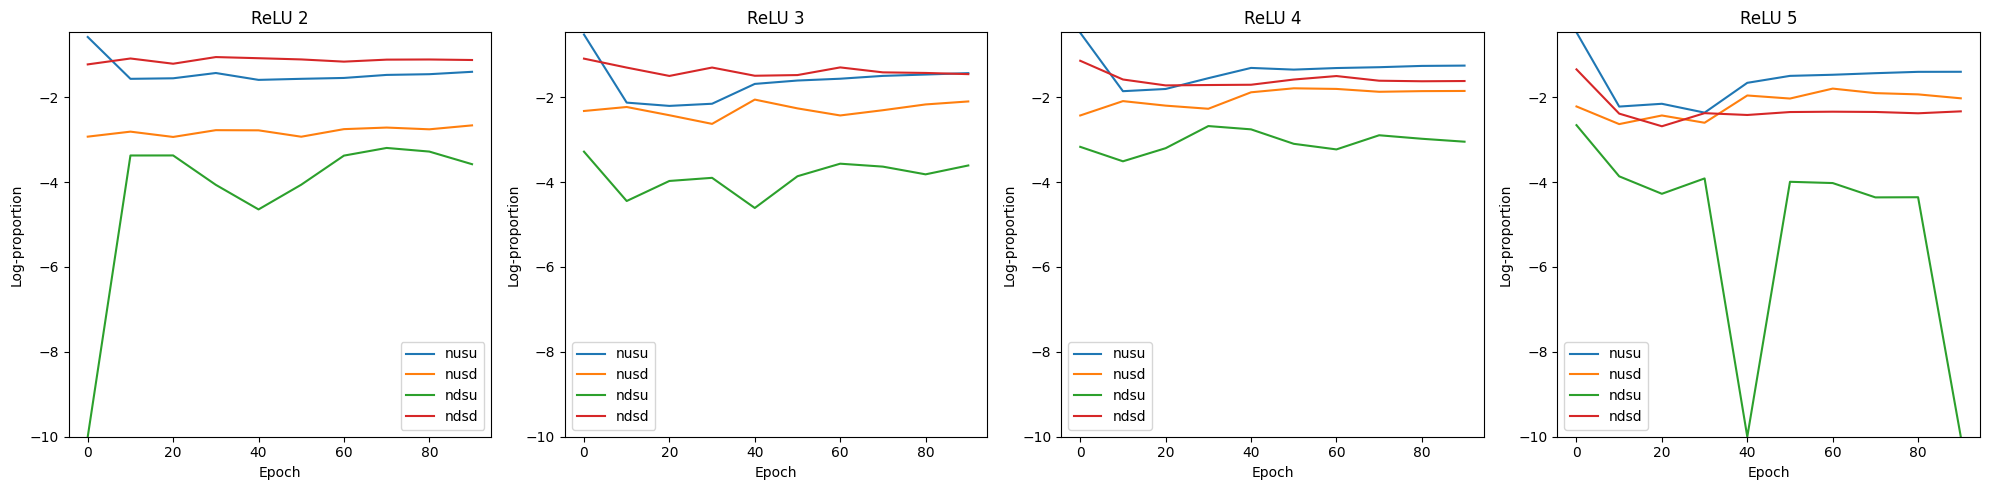

In [28]:
import matplotlib.pyplot as plt

# Initialize the list for storing the results
results = []

# Initialize variables for global min and max
global_min = float('inf')
global_max = -float('inf')

for relu in range(2,6):
    # Initialize the list for storing the results of each ReLU
    results_relu = []
    for epoch in range(0,91,10):
        pkl_filename = f'pkl/network{net}_Relu{relu}_epoch{epoch}.pkl'
        
        if os.path.exists(pkl_filename):
            try:
                with open(pkl_filename, 'rb') as f:
                    units = pickle.load(f)
                    
                sel_units = [units[i].id for i in range(len(units)) if units[i].anova2_numbers is not None and units[i].anova2_numbers < 0.01 and 
                             units[i].anova2_sizes is not None and units[i].anova2_sizes < 0.01]

                nb_mon = np.array([units[i].num_monotonicity for i in sel_units])
                sz_mon = np.array([units[i].size_monotonicity for i in sel_units])
                prfd_num = np.array([units[i].PN for i in sel_units])
                prfd_sz = np.array([units[i].PS for i in sel_units])

                nusu = np.log10(np.sum((nb_mon == 1) & (sz_mon == 1) & (prfd_num == 20) & (prfd_sz == 13))/len(sel_units) + 1e-10)
                nusd = np.log10(np.sum((nb_mon == 1) & (sz_mon == -1) & (prfd_num == 20) & (prfd_sz == 7))/len(sel_units) + 1e-10)
                ndsu = np.log10(np.sum((nb_mon == -1) & (sz_mon == 1) & (prfd_num == 2) & (prfd_sz == 13))/len(sel_units) + 1e-10)
                ndsd = np.log10(np.sum((nb_mon == -1) & (sz_mon == -1) & (prfd_num == 2) & (prfd_sz == 7))/len(sel_units) + 1e-10)
                
                # Update global min and max
                global_min = min(global_min, nusu, nusd, ndsu, ndsd)
                global_max = max(global_max, nusu, nusd, ndsu, ndsd)

                results_relu.append((epoch, nusu, nusd, ndsu, ndsd))
            except Exception as e:
                print(f"Pickle file {pkl_filename} failed to load due to error: {e}")
    results.append(results_relu)

# Generate plots
fig, axes = plt.subplots(1, 4, figsize=(20,5))

for i, results_relu in enumerate(results):
    epochs, nusu, nusd, ndsu, ndsd = zip(*results_relu)
    ax = axes[i]  # Index directly for 1-D grid
    ax.plot(epochs, nusu, label='nusu')
    ax.plot(epochs, nusd, label='nusd')
    ax.plot(epochs, ndsu, label='ndsu')
    ax.plot(epochs, ndsd, label='ndsd')
    ax.set_title(f'ReLU {i + 2}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log-proportion')
    ax.set_ylim(global_min, global_max)  # set y-axis limits to global min and max
    ax.legend()

plt.tight_layout()
plt.savefig('lineplots_num_sz_monotonicity_all_relus_logscale.pdf')
plt.show()

In [47]:
net=1; relu=5; epoch=90

pkl_filename = f'pkl/network{net}_Relu{relu}_epoch{epoch}.pkl'
        
if os.path.exists(pkl_filename):
    try:
        with open(pkl_filename, 'rb') as f:
            units = pickle.load(f)
    except Exception as e:
        print(f"Pickle file {pkl_filename} failed to load due to error: {e}")

sel_units = [units[i].id for i in range(len(units)) if units[i].anova2_numbers is not None and units[i].anova2_numbers < 0.01 and 
             units[i].anova2_sizes is not None and units[i].anova2_sizes < 0.01]

In [3]:
import scipy

vectors = [np.random.rand(10) for _ in range(5)]  # list of 5 vectors of length 10

# Transpose the list of vectors to get a list of elements at each position
element_lists = np.transpose(vectors)

# Initialize list to store correlation coefficients
spearman_coeffs = []

for elements in element_lists:
    # Compute Spearman correlation
    rho, _ = scipy.stats.spearmanr(elements, range(1, 6))  # range(1, 6) are the vector labels
    spearman_coeffs.append(rho)

In [6]:
import scipy
import numpy as np

# Assume you have a list of vectors
vectors = [np.random.rand(10) for _ in range(5)]  # list of 5 vectors of length 10

# Initialize list to store correlation coefficients
spearman_coeffs = []

for i in range(len(vectors[0])):  # assuming all vectors have the same length
    # Extract the ith element from each vector
    elements = [vec[i] for vec in vectors]

    # Compute Spearman correlation
    rho, _ = scipy.stats.spearmanr(elements, range(1, 6))  # range(1, 6) are the vector labels
    spearman_coeffs.append(rho)

# Now spearman_coeffs holds the Spearman correlation for each element position


In [8]:
actv_net = actv_analysis.get_actv_net(net=1,relu=5,epoch=0)

--- 134.86757802963257 seconds ---


In [12]:
avg_actv_net_nxs = np.mean(actv_net,axis=2).reshape(43264,10,10)[:,:,3:]

In [16]:
avg_actv_net_nxs[0,:,:]

array([[15.720653, 15.899296, 15.880209, 15.958445, 16.124348, 16.492582,
        16.611473],
       [17.815264, 18.125725, 18.179552, 18.398743, 18.825274, 19.05346 ,
        19.201433],
       [20.850182, 21.097563, 21.400013, 21.637793, 22.103483, 22.266472,
        22.716263],
       [24.68627 , 24.676176, 25.415716, 25.45082 , 25.4579  , 26.200087,
        27.088055],
       [25.14981 , 25.163023, 25.918758, 25.99257 , 26.434546, 26.636328,
        27.16213 ],
       [29.11782 , 28.847692, 29.035955, 29.241014, 29.306782, 30.069498,
        30.6234  ],
       [30.376106, 30.499432, 31.020847, 31.236414, 31.410826, 31.970476,
        31.677103],
       [33.324726, 33.162468, 33.708622, 33.619583, 33.374634, 32.86762 ,
        33.788536],
       [34.06778 , 34.147728, 34.35319 , 34.500942, 34.991745, 34.61339 ,
        35.158596],
       [36.705723, 36.418354, 35.897873, 35.993683, 35.483112, 35.194122,
        35.538887]], dtype=float32)